# 05 - Modelling

## 5.1 Table of Contents:

## 5.2 Introduction:

After completing the preprocessing phase, we have reached the modeling section of our project. Since creating new CSV files for the processed data might consume significant space on GitHub, we'll redo all the preprocessing steps and then proceed with modeling.

Our objective now is to explore five different recommendation systems, each employing a range of models, from simple formulas to machine learning algorithms and deep learning methods. We aim to determine the most effective approach for recommending movies to our clients, considering various evaluation metrics.

## 5.3 Imports & Load Data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import seaborn as sns
import scipy.stats

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV as GridSearchCV2
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split as train_test_split1
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import linear_kernel

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.optimizers import Adam

2024-04-07 16:31:30.778975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#load data
metadata = pd.read_csv('../src/data/Cleaned/metadata_postEDA.csv',index_col = 0)
ratings = pd.read_csv('../src/data/The Movies Dataset/ratings_small.csv')
links_small = pd.read_csv('../src/data/The Movies Dataset/links_small.csv')

## 5.3.1 Explore Data:

In [3]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44906 entries, 0 to 44983
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  4463 non-null   object 
 1   budget                 8851 non-null   float64
 2   genres                 44906 non-null  object 
 3   movieId                44906 non-null  int64  
 4   original_language      44896 non-null  object 
 5   overview               43999 non-null  object 
 6   popularity             44906 non-null  float64
 7   production_companies   44906 non-null  object 
 8   production_countries   44906 non-null  object 
 9   release_date           44906 non-null  object 
 10  revenue                7385 non-null   float64
 11  runtime                44666 non-null  float64
 12  spoken_languages       44906 non-null  object 
 13  tagline                20276 non-null  object 
 14  title                  44906 non-null  object 
 15  vote_av

In [4]:
metadata.T

,0,1,2,3,4,5,6,7,8,9,...,44973,44974,44975,44976,44977,44978,44980,44981,44982,44983
belongs_to_collection,Toy Story Collection,NaN,Grumpy Old Men Collection,NaN,Father of the Bride Collection,NaN,NaN,NaN,NaN,James Bond Collection,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
budget,30000000.0,65000000.0,NaN,16000000.0,NaN,60000000.0,58000000.0,NaN,35000000.0,58000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genres,"['Animation', 'Comedy', 'Family']","['Adventure', 'Fantasy', 'Family']","['Romance', 'Comedy']","['Comedy', 'Drama', 'Romance']",['Comedy'],"['Action', 'Crime', 'Drama', 'Thriller']","['Comedy', 'Romance']","['Action', 'Adventure', 'Drama', 'Family']","['Action', 'Adventure', 'Thriller']","['Adventure', 'Action', 'Thriller']",...,[],"['Horror', 'Mystery', 'Thriller']","['Mystery', 'Horror']",['Horror'],['Science Fiction'],"['Drama', 'Action', 'Romance']",['Drama'],"['Action', 'Drama', 'Thriller']",[],[]
movieId,862,8844,15602,31357,11862,949,11860,45325,9091,710,...,67179,84419,390959,289923,222848,30840,111109,67758,227506,461257
original_language,en,en,en,en,en,en,en,en,en,en,...,it,en,en,en,en,en,tl,en,en,en
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...,"Cheated on, mistreated and stepped on, the wom...",Just when George Banks has recovered from his ...,"Obsessive master thief, Neil McCauley leads a ...",An ugly duckling having undergone a remarkable...,"A mischievous young boy, Tom Sawyer, witnesses...",International action superstar Jean Claude Van...,James Bond must unmask the mysterious head of ...,...,Sentenced to life imprisonment for illegal act...,An unsuccessful sculptor saves a madman named ...,"In this true-crime documentary, we delve into ...",A film archivist revisits the story of Rustin ...,It's the year 3000 AD. The world's most danger...,"Yet another version of the classic epic, with ...",An artist struggles to finish his work while a...,"When one of her hits goes wrong, a professiona...","In a small town live two brothers, one a minis...",50 years after decriminalisation of homosexual...
popularity,21.946943,17.015539,11.7129,3.859495,8.387519,17.924927,6.677277,2.561161,5.23158,14.686036,...,0.225051,0.222814,0.076061,0.38645,0.661558,5.683753,0.178241,0.903007,0.003503,0.163015
production_companies,['Pixar Animation Studios'],"['TriStar Pictures', 'Teitler Film', 'Intersco...","['Warner Bros.', 'Lancaster Gate']",['Twentieth Century Fox Film Corporation'],"['Sandollar Productions', 'Touchstone Pictures']","['Regency Enterprises', 'Forward Pass', 'Warne...","['Paramount Pictures', 'Scott Rudin Production...",['Walt Disney Pictures'],"['Universal Pictures', 'Imperial Entertainment...","['United Artists', 'Eon Productions']",...,[],['Universal Pictures'],[],"['Neptune Salad Entertainment', 'Pirie Product...",['Concorde-New Horizons'],"['Westdeutscher Rundfunk (WDR)', 'Working Titl...",['Sine Olivia'],['American World Pictures'],['Yermoliev'],[]
production_countries,['US'],['US'],['US'],['US'],['US'],['US'],"['DE', 'US']",['US'],['US'],"['GB', 'US']",...,[],['US'],[],['US'],['US'],"['CA', 'DE', 'GB', 'US']",['PH'],['US'],['RU'],['GB']
release_date,1995-10-30,1995-12-15,1995-12-22,1995-12-22,1995-02-10,1995-12-15,1995-12-15,1995-12-22,1995-12-22,1995-11-16,...,1972-01-01,1946-03-29,2000-10-22,2000-10-03,1995-01-01,1991-05-13,2011-11-17,2003-08-01,1917-10-21,2017-06-09


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
ratings = ratings.drop(columns = 'timestamp')
ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [7]:
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
links_small.head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

## 5.3.2 Fixing Categorical Data:

Let's explore the data and alter, clean the categorical dataset and prep it for modelling.

In [8]:
#Start off by converting string of list to list of strings. 
metadata['genres'] = metadata['genres'].apply(literal_eval).apply(lambda x: [str(i) for i in x])
metadata['production_companies'] = metadata['production_companies'].apply(literal_eval).apply(lambda x: [str(i) for i in x])
metadata['production_countries'] = metadata['production_countries'].apply(literal_eval).apply(lambda x: [str(i) for i in x])
metadata['keyword'] = metadata['keyword'].apply(literal_eval).apply(lambda x: [str(i) for i in x])
metadata['spoken_languages'] = metadata['spoken_languages'].apply(literal_eval).apply(lambda x: [str(i) for i in x])
metadata['actor_names'] = metadata['actor_names'].apply(literal_eval).apply(lambda x: [str(i) for i in x])
metadata['director'] = metadata['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))

In [9]:
metadata.T

,0,1,2,3,4,5,6,7,8,9,...,44973,44974,44975,44976,44977,44978,44980,44981,44982,44983
belongs_to_collection,Toy Story Collection,NaN,Grumpy Old Men Collection,NaN,Father of the Bride Collection,NaN,NaN,NaN,NaN,James Bond Collection,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
budget,30000000.0,65000000.0,NaN,16000000.0,NaN,60000000.0,58000000.0,NaN,35000000.0,58000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genres,"[Animation, Comedy, Family]","[Adventure, Fantasy, Family]","[Romance, Comedy]","[Comedy, Drama, Romance]",[Comedy],"[Action, Crime, Drama, Thriller]","[Comedy, Romance]","[Action, Adventure, Drama, Family]","[Action, Adventure, Thriller]","[Adventure, Action, Thriller]",...,[],"[Horror, Mystery, Thriller]","[Mystery, Horror]",[Horror],[Science Fiction],"[Drama, Action, Romance]",[Drama],"[Action, Drama, Thriller]",[],[]
movieId,862,8844,15602,31357,11862,949,11860,45325,9091,710,...,67179,84419,390959,289923,222848,30840,111109,67758,227506,461257
original_language,en,en,en,en,en,en,en,en,en,en,...,it,en,en,en,en,en,tl,en,en,en
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...,"Cheated on, mistreated and stepped on, the wom...",Just when George Banks has recovered from his ...,"Obsessive master thief, Neil McCauley leads a ...",An ugly duckling having undergone a remarkable...,"A mischievous young boy, Tom Sawyer, witnesses...",International action superstar Jean Claude Van...,James Bond must unmask the mysterious head of ...,...,Sentenced to life imprisonment for illegal act...,An unsuccessful sculptor saves a madman named ...,"In this true-crime documentary, we delve into ...",A film archivist revisits the story of Rustin ...,It's the year 3000 AD. The world's most danger...,"Yet another version of the classic epic, with ...",An artist struggles to finish his work while a...,"When one of her hits goes wrong, a professiona...","In a small town live two brothers, one a minis...",50 years after decriminalisation of homosexual...
popularity,21.946943,17.015539,11.7129,3.859495,8.387519,17.924927,6.677277,2.561161,5.23158,14.686036,...,0.225051,0.222814,0.076061,0.38645,0.661558,5.683753,0.178241,0.903007,0.003503,0.163015
production_companies,[Pixar Animation Studios],"[TriStar Pictures, Teitler Film, Interscope Co...","[Warner Bros., Lancaster Gate]",[Twentieth Century Fox Film Corporation],"[Sandollar Productions, Touchstone Pictures]","[Regency Enterprises, Forward Pass, Warner Bros.]","[Paramount Pictures, Scott Rudin Productions, ...",[Walt Disney Pictures],"[Universal Pictures, Imperial Entertainment, S...","[United Artists, Eon Productions]",...,[],[Universal Pictures],[],"[Neptune Salad Entertainment, Pirie Productions]",[Concorde-New Horizons],"[Westdeutscher Rundfunk (WDR), Working Title F...",[Sine Olivia],[American World Pictures],[Yermoliev],[]
production_countries,[US],[US],[US],[US],[US],[US],"[DE, US]",[US],[US],"[GB, US]",...,[],[US],[],[US],[US],"[CA, DE, GB, US]",[PH],[US],[RU],[GB]
release_date,1995-10-30,1995-12-15,1995-12-22,1995-12-22,1995-02-10,1995-12-15,1995-12-15,1995-12-22,1995-12-22,1995-11-16,...,1972-01-01,1946-03-29,2000-10-22,2000-10-03,1995-01-01,1991-05-13,2011-11-17,2003-08-01,1917-10-21,2017-06-09


Creating a small metadata for content based modeling as the metadata is too large and requires alot of computational power that my laptop is not capable of handling. 

In [10]:
smetadata = metadata[metadata['movieId'].isin(links_small)]
smetadata.shape

(9061, 22)

## 5.4 Recommender Systems and Modelling:

This Section will be split into 4 subsection for each recommender sytem. This way we can focus on exactly whats needed for our end models rather than over engineering.

## 5.4.1 Simple Recommender System:

As Previously mentioned, Simple recommender suggests trending recommendations based on Popularity. (ie. # of votes and vote average score). I could just simply sort metadata by 'vote_average' and recommend the highest rated movie to our client. However, for this system i would like to take a different metric and use IMDB's weighted rating formula to construct my chart.

This recommender system does not have any ML algorithm, its a simple demographic based recommender without any content (cast, director, plot) or personalized (user rating) based recommendation.

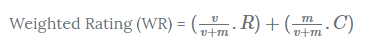

where,

* v = number of votes for the movie.
* m = minimum votes required to be listed in the chart.
* R = average rating of the movie.
* C = mean vote across the whole report.

We have v(vote_count) and R(vote_average) in our metadata. The next step is to determine an appropriate value for m and C. For m we will use 95th percentile as our cutoff and pick movies greater than this number to be considered for this list.

In [11]:
C = metadata['vote_average'].mean()
C

5.629688683026767

In [12]:
m= metadata['vote_count'].quantile(0.95)
m

440.0

In [13]:
q_movies = metadata[metadata['vote_count'] >=m]
q_movies.shape

(2248, 22)

Movie must have more than 440 votes to qualify for recommender system, this reduces our metadata to just 2248 movies.

In [14]:
#Defining our Weighted Rating function.
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    #Calculation based in imdb formula.
    return (v/(v+m) * R) + (m/(m+v) * C)

In [15]:
# Define a new feature 'WR' and calculate its value with `weighted_rating()`
q_movies['WR'] = q_movies.apply(weighted_rating, axis=1)

/var/folders/b0/49b4vqsd3gn_gr81hbd8p8wm0000gn/T/ipykernel_24412/75555458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_movies['WR'] = q_movies.apply(weighted_rating, axis=1)


In [16]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('WR', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'WR']].head(10)

,title,vote_count,vote_average,WR
313,The Shawshank Redemption,8358.0,8.5,8.356452
830,The Godfather,6024.0,8.5,8.304620
12421,The Dark Knight,12269.0,8.3,8.207551
2829,Fight Club,9678.0,8.3,8.183877
291,Pulp Fiction,8670.0,8.3,8.171028
350,Forrest Gump,8147.0,8.2,8.068297
521,Schindler's List,4436.0,8.3,8.059037
23505,Whiplash,4376.0,8.3,8.056035
5455,Spirited Away,3968.0,8.3,8.033453
15402,Inception,14075.0,8.1,8.025116


These are the **Top 10 Recommended movies** using IMDB's Weighted Rating normalization.

## 5.4.2 Content-Based Recommendation System:

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

### 5.4.2.1 Overview Based recommendation:

This is where we will be applying our learnings from feature engineering to action. The strategy here would be to first normalize free text data and then use similarty algorithms to find related movies.

In [17]:
## Lets start by removing unwanted characters and applying lowercase to overview feature.
smetadata['overview'] = smetadata['overview'].fillna('')

# Replace all non letter characters with a whitespace
smetadata['overview'] = smetadata['overview'].str.replace('[^a-zA-Z]', ' ')

# Change to lower case
smetadata['overview']  = smetadata['overview'].str.lower()

# Print the first 5 rows of the overview column
smetadata['overview'] .head()

/var/folders/b0/49b4vqsd3gn_gr81hbd8p8wm0000gn/T/ipykernel_24412/4153281438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smetadata['overview'] = smetadata['overview'].fillna('')
/var/folders/b0/49b4vqsd3gn_gr81hbd8p8wm0000gn/T/ipykernel_24412/4153281438.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smetadata['overview'] = smetadata['overview'].str.replace('[^a-zA-Z]', ' ')
/var/folders/b0/49b4vqsd3gn_gr81hbd8p8wm0000gn/T/ipykernel_24412/4153281438.py:8: SettingWithCopyWarning: 
A value is tryin

0    led by woody, andy's toys live happily in his ...
1    when siblings judy and peter discover an encha...
2    a family wedding reignites the ancient feud be...
3    cheated on, mistreated and stepped on, the wom...
4    just when george banks has recovered from his ...
Name: overview, dtype: object

Since 'Overview' is a free text data, we the option in Scikit learn module to normalize the dataset.

TF-iDF = Term Frequency inverse Document Frequency, as a base function we can use it to give each word in the text a score. This particular text normalizer reduces the score of repetative words like 'the', 'and' etc.


### TF-iDF Text Normalization

In [18]:
# Instantiate TfidfVectorizer
tv = TfidfVectorizer(stop_words='english')

# Fit the vectroizer and transform the data
tv_transformed = tv.fit_transform(smetadata['overview'])

# Create new features for the test set
tv_df = pd.DataFrame(tv_transformed.toarray(), 
                          columns=tv.get_feature_names_out()).add_prefix('TFIDF_')

In [19]:
tv_df.shape

(9061, 29694)

We have ~24k unique words in 9061 movies.

In [20]:
tv_df.head()

,TFIDF_00,TFIDF_000,TFIDF_007,TFIDF_01,TFIDF_05pm,TFIDF_10,TFIDF_100,TFIDF_1000,TFIDF_100th,TFIDF_101,...,TFIDF_æon,TFIDF_édith,TFIDF_élan,TFIDF_émigré,TFIDF_état,TFIDF_étienne,TFIDF_évocateur,TFIDF_ôtomo,TFIDF_østergaard,TFIDF_žižek
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Isolate the row to be examined
sample_row = tv_df.iloc[0]

# Print the top 5 words of the sorted output
print(sample_row.sort_values(ascending=False).head())

TFIDF_buzz         0.492752
TFIDF_woody        0.446232
TFIDF_andy         0.426704
TFIDF_lightyear    0.187050
TFIDF_toys         0.160086
Name: 0, dtype: float64


### Model 1: Cosine Similarity with Plot Overview:

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:

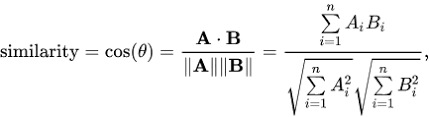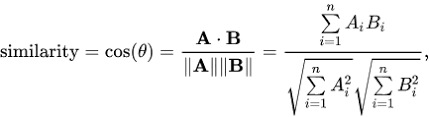

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

In [22]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tv_df, tv_df)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies with similarity scores. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [23]:
#Construct a reverse map of indices and movie titles
smetadata = smetadata.reset_index()
indices = pd.Series(smetadata.index, index=smetadata['title'])

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-

* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements with similarity scores.

In [24]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Get the similarity scores
    similarity_scores = [i[1] for i in sim_scores]

    # Create a DataFrame to store the results
    recommendations_df = pd.DataFrame({'Movie Title': smetadata['title'].iloc[movie_indices],
                                       'Similarity Score': similarity_scores})

    return recommendations_df

In [25]:
get_recommendations('The Dark Knight', cosine_sim)

,Movie Title,Similarity Score
7912,The Dark Knight Rises,0.306073
1111,Batman Returns,0.250307
7548,Batman: Under the Red Hood,0.232907
8206,"Batman: The Dark Knight Returns, Part 2",0.221500
132,Batman Forever,0.218481
8145,"Batman: The Dark Knight Returns, Part 1",0.189770
524,Batman,0.178657
7882,Batman: Year One,0.177141
2573,Batman: Mask of the Phantasm,0.175289
6130,Batman Begins,0.158861


In [26]:
get_recommendations('Spider-Man', cosine_sim)

,Movie Title,Similarity Score
6661,Spider-Man 3,0.274121
8507,The Amazing Spider-Man 2,0.232365
8047,The Amazing Spider-Man,0.217347
5464,Spider-Man 2,0.200145
2152,Arachnophobia,0.194870
1560,Gremlins 2: The New Batch,0.168851
7472,Kick-Ass,0.146404
4078,The New Guy,0.133718
2451,Poison Ivy,0.126569
5207,Bang Bang You're Dead,0.119180


We see that for The Dark Knight, our system is able to identify it as a Batman film and subsequently recommend other Batman films as its top recommendations. But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie. 

### 5.4.2.2 Keyword, Genre, Cast and Director based Recommendation:

### Creating a feature of word soup

Here we try to create a new feature with all keyword, genre, cast and director combined. But first lets trim down the some of these features to only look at the top 3 elements in the list.

In [27]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(names):
    if isinstance(names, list):
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [28]:
features = ['actor_names','keyword', 'genres']
for feature in features:
    smetadata[feature] = smetadata[feature].apply(get_list)

In [29]:
#Checking database of the altered feature to ensure we have 3 elements or less.
smetadata[['title','actor_names', 'director', 'keyword', 'genres']].head(3)

,title,actor_names,director,keyword,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",johnlasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",joejohnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",howarddeutch,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"


Time to clean up the dataset by making them all lower case and removing spaces.

In [30]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [31]:
# Apply clean_data function to your features.
features = ['actor_names', 'director', 'keyword', 'genres']

for feature in features:
    smetadata[feature] = smetadata[feature].apply(clean_data)

In [32]:
#Checking database of the altered features.
smetadata[['title','actor_names', 'director', 'keyword', 'genres']].head(3)

,title,actor_names,director,keyword,genres
0,Toy Story,"[tomhanks, timallen, donrickles]",johnlasseter,"[jealousy, toy, boy]","[animation, comedy, family]"
1,Jumanji,"[robinwilliams, jonathanhyde, kirstendunst]",joejohnston,"[boardgame, disappearance, basedonchildren'sbook]","[adventure, fantasy, family]"
2,Grumpier Old Men,"[waltermatthau, jacklemmon, ann-margret]",howarddeutch,"[fishing, bestfriend, duringcreditsstinger]","[romance, comedy]"


Now we can go ahead and create a word soup of our features.

In [33]:
def create_soup(x):
    return ' '.join(x['keyword']) + ' ' + ' '.join(x['actor_names']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
smetadata['soup'] = smetadata.apply(create_soup, axis=1)

In [34]:
#Verify new feature
smetadata[['title', 'soup']].head(3)

,title,soup
0,Toy Story,jealousy toy boy tomhanks timallen donrickles ...
1,Jumanji,boardgame disappearance basedonchildren'sbook ...
2,Grumpier Old Men,fishing bestfriend duringcreditsstinger walter...


### Count Vectorizer

Now we follow the same step as before to normalize the text data, this time it's not free text data and we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. Therefore, we will be using a Count Vectorizer instead of TF-iDF.

In [35]:
cv = CountVectorizer(stop_words='english')
cv_transformed = cv.fit_transform(smetadata['soup'])

# Create new features for the test set
cv_df = pd.DataFrame(cv_transformed.toarray(), 
                          columns=cv.get_feature_names_out()).add_prefix('CV_')

In [36]:
cv_df.shape

(9061, 19170)

Interestingly we also have roughly 19k unique words for 9K movies.

In [37]:
cv_df.head()

,CV_17thcentury,CV_18thcentury,CV_1910s,CV_1930s,CV_1960s,CV_1970s,CV_1995,CV_3d,CV_50cent,CV_aaliyah,...,CV_битва,CV_воин,CV_дэмианчапа,CV_любовь,CV_моррисчестнат,CV_томву,CV_эрикаэлениак,CV_卧底肥妈,CV_松隆子,CV_绝地奶霸
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Isolate the row to be examined
sample_row = cv_df.iloc[0]

# Print the top 5 words of the sorted output
print(sample_row.sort_values(ascending=False).head())

CV_comedy        1
CV_animation     1
CV_timallen      1
CV_donrickles    1
CV_boy           1
Name: 0, dtype: int64


### Model 2: Cosine Similarity with Keyword, Genre, Cast and Director:

In [39]:
# Compute the cosine similarity matrix
cosine_sim2 = linear_kernel(cv_df, cv_df)

In [40]:
get_recommendations('The Dark Knight', cosine_sim2)

,Movie Title,Similarity Score
7912,The Dark Knight Rises,8.0
6130,Batman Begins,7.0
5362,Mitchell,5.0
3769,Iron Monkey,4.0
6528,The Prestige,4.0
6806,Hitman,4.0
7472,Kick-Ass,4.0
8338,Kick-Ass 2,4.0
5,Heat,3.0
40,Dead Presidents,3.0


In [41]:
get_recommendations('Spider-Man', cosine_sim2)

,Movie Title,Similarity Score
5464,Spider-Man 2,5.0
6661,Spider-Man 3,5.0
3095,Highlander: Endgame,3.0
7338,Cirque du Freak: The Vampire's Assistant,3.0
7388,Daybreakers,3.0
7732,Sucker Punch,3.0
1,Jumanji,2.0
42,Mortal Kombat,2.0
132,Batman Forever,2.0
271,The Quick and the Dead,2.0


The similarity score here is in a different scale than that of overview recommendation. This is due to the count vectorizer normalization. Therefore, we cannot compare them using the same metric. There are several candidate for similarity scores; such as the euclidean, the Pearson and the cosine similarity scores. There is no right answer to which score is the best and they are not easily compared using any metric, therefore, we will just stick to Cosine Similarty.

That being said, we can still look at our results and validate how well our ML model is peforming. For Example, we see that in The Dark Knight recommendation using metadata suggest movies with christopher nolan as director more often, same with recommendations for Spider-Man where movies recommendations like 'The Quick and the Dead' are all from director Sam Raimi.

## 5.4.3 Collaborative Recommendation System:

Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

### Train & Test Data Split:

In [42]:
ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


The goal here is to predict rating given 'movieID' and 'UserID'. Lets start off by splitting the dataset for modelling.

In [43]:
X = ratings.drop([ 'rating'] ,axis=1)
y = ratings.rating

In [44]:
#Setting aside 20% of the data set for test purposes. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

In [45]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(80003, 2) (20001, 2)
(80003,) (20001,)


### Dummy Classification Model:

In [46]:
# Dummy Classifier (using most frequent strategy)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)

# Calculate Mean Absolute Error (MAE)
dummy_mae = mean_absolute_error(y_test, dummy_pred)
# Calculate Root Mean Squared Error (RMSE)
dummy_rmse = mean_squared_error(y_test, dummy_pred, squared=False)

print("Dummy Classifier MAE:", dummy_mae)
print("Dummy Classifier RMSE:", dummy_rmse)

Dummy Classifier MAE: 0.8342582870856458
Dummy Classifier RMSE: 1.1508078823421817


Although Classification is not the right approach for our problem, its a good start to understand what to expect and how we can improve from here.

### Model 3: SVD - Singular Value Decomposition:

As you have probably noticed, we plan on using MAE and RMSE to score our model for collaborating filtering. 

In [47]:
# Load the dataset
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [48]:
# Instantiate the SVD algorithm
svd = SVD()
# Perform 5-fold cross-validation
cv_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8859  0.8930  0.9054  0.9022  0.8946  0.8962  0.0069  
MAE (testset)     0.6815  0.6885  0.6968  0.6957  0.6895  0.6904  0.0055  
Fit time          1.09    1.00    0.92    0.97    1.00    1.00    0.05    
Test time         0.18    0.09    0.09    0.10    0.09    0.11    0.03    


MAE: The MAE score of 0.6893 indicates that, on average, our model's rating predictions are off by 0.6893 from the original rating.

RMSE: The RMSE score of 0.8957 indicates that, on average, the deviation of our model's predictions from rating is approximately 0.8957. This value is slightly higher than the MAE because RMSE penalizes larger errors more heavily.

### Model 4: NMF - Non-negative Matrix factorization:

In [49]:
from surprise import NMF

In [50]:
# Instantiate the NMF algorithm
nmf = NMF()

# Perform 5-fold cross-validation
cv_results = cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9377  0.9515  0.9468  0.9525  0.9536  0.9484  0.0058  
MAE (testset)     0.7171  0.7322  0.7265  0.7301  0.7353  0.7283  0.0063  
Fit time          2.03    2.01    2.16    2.09    2.08    2.07    0.05    
Test time         0.08    0.07    0.07    0.07    0.07    0.07    0.00    


MAE and RMSE are worse than SVD algorithm.

### Model 5: Deep Learning Based approach: Neural Collaborative Filtering

In [51]:
# Encode userId and movieId
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['item'] = item_enc.fit_transform(ratings['movieId'].values)
n_items = ratings['item'].nunique()

# Define embedding size
embedding_size = 50

# Define input layers
user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

# User and item embedding layers
user_embedding = Embedding(input_dim=n_users, output_dim=embedding_size)(user_input)
item_embedding = Embedding(input_dim=n_items, output_dim=embedding_size)(item_input)

# Flatten the embeddings
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

# Concatenate user and item embeddings
input_vecs = Concatenate()([user_vecs, item_vecs])

# Fully connected layers
x = Dense(64, activation='relu')(input_vecs)
x = Dense(32, activation='relu')(x)
output = Dense(1)(x)

# Create model
model = Model(inputs=[user_input, item_input], outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Splitting data into train and test sets
train, test = train_test_split(ratings, test_size=0.2, random_state=100)

# Train model
history = model.fit([train['user'], train['item']], train['rating'], 
                    batch_size=64, epochs=10, verbose=0)

# Predict ratings on test set
preds = model.predict([test['user'], test['item']]).squeeze()

# Evaluate model using RMSE and MAE
rmse = np.sqrt(mean_squared_error(test['rating'], preds))
mae = mean_absolute_error(test['rating'], preds)

print("RMSE:", rmse)
print("MAE:", mae)

626/626 [==============================] - 1s 1ms/step
RMSE: 0.9558738323362419
MAE: 0.7345631505678811


Out of the 3 Models for Collaborative the best one seems to be SVD - Singular Value Decomposition. Lets use this for our final model, but before we can get started, let's tune the hyper-parameters. 

### Best Model - SVD - Hyperparameter Tuning:

In [53]:
# Define parameter grid
param_grid = {'n_factors': [50, 100, 150], 'lr_all': [0.005, 0.01], 'reg_all': [0.02, 0.1]}

# Initialize SVD
svd = SVD()

# Perform grid search
# Perform GridSearchCV
grid_search = GridSearchCV(SVD, param_grid=param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=1)
grid_search.fit(data)

# Print the best RMSE score
print("Best RMSE score:", grid_search.best_score['rmse'])

# Print the best RMSE parameters
print("Best RMSE parameters:", grid_search.best_params['rmse'])

# Print the best MAE score
print("Best MAE score:", grid_search.best_score['mae'])

# Print the best MAE parameters
print("Best MAE parameters:", grid_search.best_params['mae'])

Best RMSE score: 0.8831725637745075
Best RMSE parameters: {'n_factors': 150, 'lr_all': 0.01, 'reg_all': 0.1}
Best MAE score: 0.6798037615021535
Best MAE parameters: {'n_factors': 150, 'lr_all': 0.01, 'reg_all': 0.1}


With these new hyperparameters, we were able to reduce the RMSE and MAE ever so slightly. 

* RMSE Score went from **0.90** to **0.88**.
* MAE Score reduced from **0.69** to **0.68**.

For our Model, this is sufficient to move on with predictions. 

In [54]:
# Fit the data using the best parameters
best_svd = grid_search.best_estimator['rmse']
best_svd.fit(data.build_full_trainset())

### Best Model - SVD - Predictions

Let's start off by displaying all movies watched and rated by **'userID' = 1**.

In [55]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,user,item
0,1,31,2.5,0,30
1,1,1029,3.0,0,833
2,1,1061,3.0,0,859
3,1,1129,2.0,0,906
4,1,1172,4.0,0,931
5,1,1263,2.0,0,1017
6,1,1287,2.0,0,1041
7,1,1293,2.0,0,1047
8,1,1339,3.5,0,1083
9,1,1343,2.0,0,1087


We can begin by evaluating our prediction model on movies that the user has already watched. We'll compare the model's predicted scores with the actual ratings to assess our model's accuracy.

**svd.Predict - Input Parameters:**

* uid: The user ID for whom you want to make predictions.
* iid: The item ID for the item you want to predict the rating for.
* r_ui (optional): The actual rating given by the user for the item. This parameter is optional and is used for evaluating the model's performance.

**svd.Predict - Output:**

Returns a Prediction object containing:
* uid: The user ID.
* iid: The item ID.
* est: The estimated rating for the item by the user.

In [56]:
best_svd.predict(1, 31, 2.5)

Prediction(uid=1, iid=31, r_ui=2.5, est=2.4668681505562953, details={'was_impossible': False})

In [57]:
best_svd.predict(1, 1172, 4)

Prediction(uid=1, iid=1172, r_ui=4, est=3.406306197432215, details={'was_impossible': False})

We observe that the predicted ratings closely align with the actual ratings, with minor discrepancies attributable to the inherent inaccuracies in our model, as indicated by our RMSE and MAE scores. Importantly, these ratings fall within the expected range of our evaluation metrics.

Now, let's explore some movies the user has yet to watch.

In [58]:
best_svd.predict(1, 35836)

Prediction(uid=1, iid=35836, r_ui=None, est=2.696398443263975, details={'was_impossible': False})

In [59]:
best_svd.predict(1, 39)

Prediction(uid=1, iid=39, r_ui=None, est=2.73786542298938, details={'was_impossible': False})

Here we see a predicted score of 2.69 for movieId = 35836 and score of 2.7 for movieId = 39. 

As you may have noticed, this recommendor system does not require the name or any metadata to recommend movies, it is purely based on personalized ratings for a movie based on other users with similar movie tastes.

Now, what if we combine both content based recommendations (metadata) and collaborative based recommendations (personalized). This would be our Hybrid recommendation system.

## 5.4.4 Hybrid Recommendation System:

In this segment, I aim to construct a straightforward hybrid recommender that merges techniques utilized in both content-based and collaborative filtering engines. Here's how it will operate:

* **Input:** User ID and the Title of a Movie
* **Output:** Similar movies sorted on the basis of expected ratings by that particular user.

In [60]:
id_map = links_small.to_frame()  # Convert Series to DataFrame
id_map.columns = ['movieId']
id_map = id_map.merge(smetadata[['title', 'movieId']], on='movieId').set_index('title')
#id_map = id_map.set_index('tmdbId')
id_map

,movieId
title,
Toy Story,862
Jumanji,8844
Grumpier Old Men,15602
Waiting to Exhale,31357
Father of the Bride Part II,11862
...,...
The Last Brickmaker in America,159550
Rustom,392572
Mohenjo Daro,402672


In [61]:
indices_map = id_map.set_index('movieId')

In [69]:
def hybrid(userId, title):
    # Get the index of the movie title
    idx = indices[title]
    # Compute cosine similarity scores between movies
    sim_scores = list(enumerate(cosine_sim2[int(idx)]))
    # Sort similarity scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Exclude the first item since it's the input movie itself (with similarity score of 1)
    sim_scores = sim_scores[1:26]
    # Extract indices of top 25 similar movies
    movie_indices = [i[0] for i in sim_scores]
    # Select movie information based on indices of similar movies
    movies = smetadata.iloc[movie_indices][['movieId', 'title', 'vote_count', 'vote_average', 'release_year']]
    # Estimate ratings for similar movies using the best_svd model
    movies['Rating_Est'] = movies['movieId'].apply(lambda x: best_svd.predict(userId, x).est)
    # Sort movies based on estimated ratings in descending order
    movies = movies.sort_values('Rating_Est', ascending=False)
    # Return top 10 recommended movies
    return movies.head(10)

In [72]:
hybrid(1, 'The Dark Knight')

,movieId,title,vote_count,vote_average,release_year,Rating_Est
6130,272,Batman Begins,7511.0,7.5,2005,3.098182
7912,49026,The Dark Knight Rises,9263.0,7.6,2012,2.646276
1215,31017,"Truth or Consequences, N.M.",15.0,5.7,1997,2.646276
1189,9311,Smilla's Sense of Snow,61.0,6.6,1997,2.646276
968,10835,The Killer,179.0,7.6,1989,2.646276
800,9400,Set It Off,66.0,6.9,1996,2.646276
798,9333,Last Man Standing,263.0,6.2,1996,2.646276
699,410921,Nothing to Lose,0.0,0.0,1994,2.646276
620,26744,Force of Evil,33.0,6.6,1948,2.646276
440,9516,Menace II Society,179.0,7.2,1993,2.646276


In [71]:
hybrid(1, 'Spider-Man')

,movieId,title,vote_count,vote_average,release_year,Rating_Est
965,766,Army of Darkness,852.0,7.3,1992,3.086328
6661,559,Spider-Man 3,3687.0,5.9,2007,2.979001
357,8011,Highlander: The Final Dimension,110.0,4.5,1994,2.784549
524,268,Batman,2145.0,7.0,1989,2.733336
1111,364,Batman Returns,1706.0,6.6,1992,2.666266
318,9495,The Crow,980.0,7.3,1994,2.646276
314,9331,Clear and Present Danger,390.0,6.4,1994,2.646276
886,744,Top Gun,1736.0,6.7,1986,2.646276
876,792,Platoon,1236.0,7.5,1986,2.646276
677,10546,The Crow: City of Angels,119.0,5.2,1996,2.646276


As evident from the Hybrid recommendations, it offers a blend of movies akin to "Spider-Man" or "The Dark Knight," accompanied by personalized ratings tailored to the client's preferences. This appears to be an optimal final model for the client.